In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import helper_classes.PreProcessData as preprocess
from helper_classes.DatabaseHelper import fetch_all_items, get_evaluation_score
from helper_classes.Metrics import recall, precision, mrr
from helper_classes.Evaluation import Evaluator

Find items that user has visited. Since each row in the database has also 'session_id' it is easy to distingues which item was visited during which session.

At the end we will have a dataframe as follows:
 
|userID|itemSequence|
|--|--|
|12345| [ [seq_1], [seq_2], [seq_3] ] |

In [3]:
sequence_test = preprocess.concat_user_sequences(sequence_low_limit=2)
sequence_test.head()

,userID,itemSequence
0,715904,"[[1432, 5932, 7070, 2200, 2201, 6198, 7078, 68..."
1,883157,"[[3686, 3686, 5931, 6941, 3126, 4125, 3127, 10..."
2,1050097,"[[7176, 7095], [5577, 6155]]"
3,1137872,"[[7096, 3666, 3666, 7127, 6710, 5932, 5932, 57..."
4,1179818,"[[2067, 4108], [2067, 7094, 6533, 6155, 7095, ..."


We need to export this dataframe into a list so it can be used during item2vec training.

In [4]:
train_data = sequence_test.values.tolist()
print(train_data[:1])

[[715904, [['1432', '5932', '7070', '2200', '2201', '6198', '7078', '6866', '6846', '6857', '7043', '7042', '6858', '6862', '6865', '6848', '6859', '6827'], ['5946', '5582', '5924', '7117', '5612', '5583', '3819', '3824', '5454', '3911', '4258', '6886', '1283', '5325', '6969', '7130', '725', '6767', '5932', '5932', '6256', '7070', '6828'], ['5706', '5706', '2067', '725', '725', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '2313', '5683', '5684', '5705'], ['5710', '4710', '5709', '5708', '5714', '6908', '5715', '6971'], ['7137', '7136', '5612', '5583', '5613', '1507', '5577']

Load Item2Vec Model

In [5]:
model_path = f'D:/Thesis/recsys_thesis/models/item2vec.model'
file = open(model_path, 'rb')
model = pickle.load(file)

For the fast verification, I am fetching the all items from the database. When Item2Vec creates recommendation it is a good practice to verify the recommended item is actullay in our dataset.

In [6]:
items = fetch_all_items()
print(items[:5])

[104, 3282, 6874, 1613, 6933]


Evaluation Metrics:
 1. **metrics**
		 - Precision: What proportion of positive identifications was actually correct?
		 - Recall: What proportion of actual positives was identified correctly?
		 - Mrr: Measure to evaluate systems that return a ranked list of answers to queries
 3. **model_name:** Name of the recommendation model. 
 4. **given_k:** Number of items user will has in her/his profile
 5. **look_ahead:** Ground Truth top_n => Number of items to consider for
 6. **prediction step:** How many steps will be taken after the evaluation.


In [7]:
metrics = {'precision': precision, 'recall': recall, 'mrr': mrr}
model_name = 'i2v'
given_k = 1
look_ahead = 'all'
top_n = 10
step = 1

In [ ]:
for user_id, user_sequence in train_data:
    item2vec_evaluator = Evaluator(recommender_model=model,
                                   recommender_name=model_name,
                                   metrics=metrics,
                                   items=items,
                                   test_sequence=user_sequence,
                                   given_k=given_k,
                                   look_ahead=look_ahead,
                                   top_n=top_n,
                                   step=step)
    
    evaluation_result = item2vec_evaluator.sequential_evaluation()
    
    
    metric_results = list(zip(metrics.keys(), evaluation_result))
    
    user_average_precision = round(metric_results[0][1], 2)
    user_average_recall = round(metric_results[1][1], 2)
    user_average_mrr = round(metric_results[2][1], 2)
    
    print(f'User {user_id} has been evaluated.. >> {user_average_precision} >> {user_average_recall} >> {user_average_mrr}')

After evaluating the model, retrieve the results from the database.

In [8]:
user_scores = get_evaluation_score('i2v')

In [9]:
df_user_scores = pd.DataFrame(user_scores, columns=['user_id', 'avg_precision', 'avg_recall', 'avg_mrr'])
df_user_scores['user_id'] = df_user_scores['user_id'].astype(int)
df_user_scores['avg_precision'] = df_user_scores['avg_precision'].astype(float)
df_user_scores['avg_recall'] = df_user_scores['avg_recall'].astype(float)
df_user_scores['avg_mrr'] = df_user_scores['avg_mrr'].astype(float)
df_user_scores.head()

,user_id,avg_precision,avg_recall,avg_mrr
0,3374824,1.0,0.53,1.0
1,3396036,0.7,0.64,1.0
2,3378787,0.6,0.67,1.0
3,3000415,0.5,0.83,1.0
4,3383094,0.5,0.71,1.0


In [10]:
distinct_user_count = len(df_user_scores)
print('Nummber of the unique user count: ', distinct_user_count)

Nummber of the unique user count:  3605


Get the number of 'hits'

In [11]:
hit_counter = np.count_nonzero(df_user_scores['avg_precision'])
not_hit_counter = distinct_user_count - hit_counter
print(hit_counter)

1242


In [12]:
import seaborn as sns

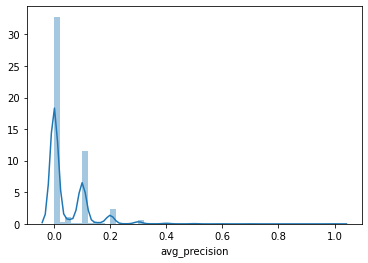

In [13]:
sns.distplot(df_user_scores['avg_precision'])

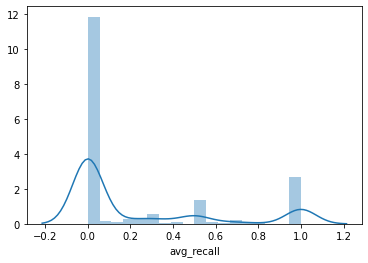

In [14]:
sns.distplot(df_user_scores['avg_recall'])

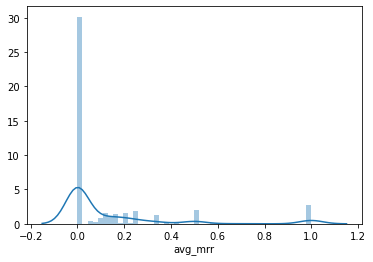

In [15]:
sns.distplot(df_user_scores['avg_mrr'])

In [16]:
def test(row):
    if (row.avg_precision > 0) and (row.avg_recall > 0) and (row.avg_mrr > 0):
        return 1
    else:
        return 0

In [17]:
df_user_scores['hit'] = df_user_scores.apply(test, axis=1)

In [18]:
df_user_scores.head()

,user_id,avg_precision,avg_recall,avg_mrr,hit
0,3374824,1.0,0.53,1.0,1
1,3396036,0.7,0.64,1.0,1
2,3378787,0.6,0.67,1.0,1
3,3000415,0.5,0.83,1.0,1
4,3383094,0.5,0.71,1.0,1


In [19]:
number_of_hits = len(df_user_scores[df_user_scores['hit'] == 1])
print('Number of hits: ', number_of_hits)

Number of hits:  1242


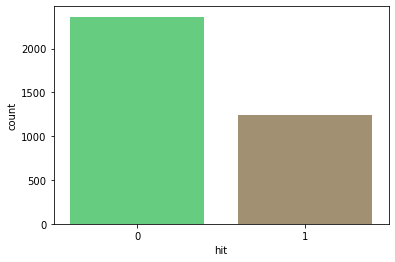

In [20]:
sns.countplot(x='hit',data=df_user_scores, palette='terrain')

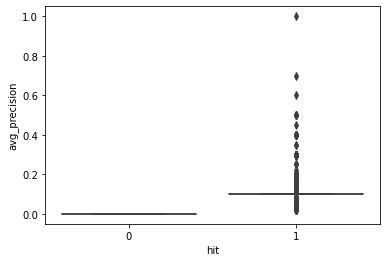

In [21]:
sns.boxplot(x='hit', y='avg_precision', data=df_user_scores)

In [22]:
df_user_scores.drop(columns=['user_id'], inplace=True)
df_user_scores.drop(columns=['hit'], inplace=True)

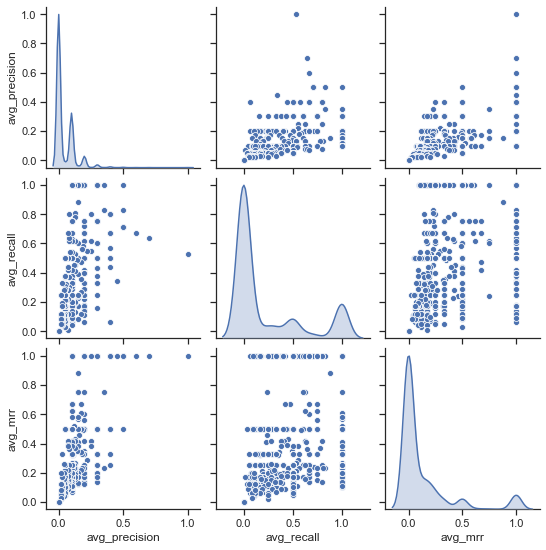

In [23]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(df_user_scores, diag_kind="kde")